In [18]:
import warnings
warnings.filterwarnings('ignore')

import time
import os
import re
import pandas as pd
import random

from matplotlib import rc, rcParams
import matplotlib.pyplot as plt
import matplotlib as mpl
import matplotlib.lines as mlines
from   matplotlib.lines import Line2D
from   matplotlib.colors import ListedColormap
import matplotlib.ticker as tk

import numpy as np
from numpy import ndarray

from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.decomposition import PCA
from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error 
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import explained_variance_score
from scipy.stats import truncnorm

import multiprocessing
import pickle
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.layers import (Input, Dropout, LSTM, Reshape, LeakyReLU,
                          Concatenate, ReLU, Flatten, Dense, Embedding,
                          BatchNormalization, Activation, SpatialDropout1D,
                          Conv2D, MaxPooling2D, UpSampling2D, Lambda)
from tensorflow.keras.models     import Model, load_model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses     import mse, binary_crossentropy
import tensorflow.keras.backend as K
from tensorflow.keras.metrics import RootMeanSquaredError
from tensorflow.keras.metrics import  mean_squared_error as mse_keras
from tensorflow.keras.backend import argmax as argmax
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow import one_hot
from tensorflow.keras.models import Sequential 

from tensorflow.keras.utils import  to_categorical
from tensorflow import random as randomtf

from IPython.display import clear_output


from progressbar import ProgressBar
import seaborn as sns

from chainer_chemistry.dataset.preprocessors import GGNNPreprocessor, construct_atomic_number_array
preprocessor = GGNNPreprocessor()
from rdkit import rdBase
rdBase.DisableLog('rdApp.error')
from rdkit import Chem

import ntpath
from scipy.stats import truncnorm

# import general file from utils as shared packages
import sys
sys.path.append("./../utils/")
from general import *

randomtf.set_seed(10)
os.environ['PYTHONHASHSEED'] = '10'
np.random.seed(420)
random.seed(123450)
from progressbar import ProgressBar

In [19]:
# GPU memory control
gpu_options = tf.compat.v1.GPUOptions(per_process_gpu_memory_fraction=0.7)
session_conf = tf.compat.v1.ConfigProto(intra_op_parallelism_threads=1, 
                                        inter_op_parallelism_threads=1, gpu_options=gpu_options)
tf.compat.v1.set_random_seed(1234)
sess = tf.compat.v1.Session(graph=tf.compat.v1.get_default_graph(), config=session_conf)
tf.compat.v1.keras.backend.set_session(sess)
tf.compat.v1.keras.backend.clear_session()

2023-08-14 00:12:24.345406: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-08-14 00:12:24.345571: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-08-14 00:12:24.345648: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-08-14 00:12:24.345747: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-08-14 00:12:24.345806: I tensorflow/compiler/xla/stream_executo

Text(0.5, 0, '!!!Ariaaaal')

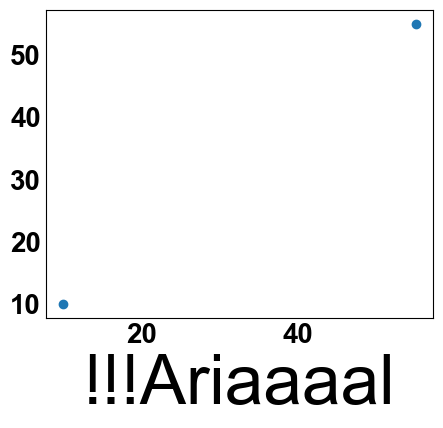

In [20]:
# check the font !!!!!!!!!!!!!!!!!!!!!
# switch to Arial
# if not working in Linux delet ~/.catch/matplotlib
plt.rcParams["font.family"] = "Arial"
plt.rcParams['ps.useafm'] = True
plt.rcParams['pdf.fonttype'] = 42
mpl.font_manager.FontManager()

rc('font', weight='bold')
fig, ax = plt.subplots(figsize=(5, 4))
plt.scatter([10, 55], [10, 55])
ax.tick_params(axis='both', length=0, width=1.5, colors='black', grid_alpha=0, labelsize=20)
plt.xlabel('!!!Ariaaaal', fontname='Arial', fontsize=50)

In [21]:
""" reading and preprocessing data"""
with open('./../data/trainingsets/train_regular_pubqc130K/image_train.pickle', 'rb') as f:
    X_smiles_train0, SMILES_train0, y_train00 = pickle.load(f)
    
with open('./../data/trainingsets/train_regular_pubqc130K/image_test.pickle', 'rb') as f:
    X_smiles_val0, SMILES_val0, y_val00 = pickle.load(f)

with open('./../data/trainingsets/train_regular_pubqc130K/tokenizer.pickle', 'rb') as f:
    tokenizer = pickle.load(f)
tokenizer[0] = ' '

with open('./../data/trainingsets/train_regular_pubqc130K/tokenizer_object.pickle', 'rb') as f:
    tokenizer_ = pickle.load(f)
    
print (X_smiles_train0.shape)
print (X_smiles_val0.shape)

(106101, 40, 27, 1)
(24819, 40, 27, 1)


In [22]:
# In case of reduceing the number of samples
idx = np.random.choice(len(y_train00), int(len(y_train00) * 1), replace = False)
X_smiles_train, SMILES_train, y_train0 = (X_smiles_train0[idx], SMILES_train0[idx], y_train00[idx])
idx = np.random.choice(len(y_val00), int(len(y_val00) * 1), replace = False)
X_smiles_val, SMILES_val, y_val0 = (X_smiles_val0[idx], SMILES_val0[idx], y_val00[idx])

print (X_smiles_train.shape)
print (X_smiles_val.shape)

(106101, 40, 27, 1)
(24819, 40, 27, 1)


In [23]:
print (min(y_train00))
print (max(y_train00))
print (min(y_val0))
print (max(y_val0))

1.048
10.985
1.148
10.757


In [24]:
# Standardized between 0 and 11
gap_min = 0
gap_max = 11

y_val = NormalizeData(y_val0, min_data=gap_min, max_data=gap_max)
y_train = NormalizeData(y_train0, min_data=gap_min, max_data=gap_max)

print (max(y_val))
print (max(y_train))

0.9779090909090908
0.9986363636363635


In [25]:
""" models definition and extracting pretrained encoder and decoder """
# encoder and decoder should be trained using another file named embedding.
encoder = load_model('./../data/nns/keep/encoder.h5')
decoder = load_model('./../data/nns/keep/decoder.h5')

class Config:
    
    def __init__(self):
        self.Filters = [256, 128, 64]
        self.genFilters = [128, 128, 128]
        self.upFilters = [(2, 2), (2, 2), (2, 2)]
        
config = Config()

## Generator 
z = Input(shape = (128, ))
y = Input(shape = (1, ))

h = Concatenate(axis = 1)([z, y])
h = Dense(1 * 1 * 128)(h)
R1 = Reshape([1, 1, 128])(h)
R2 = Reshape([1, 1, 128])(h)

for i in range(3):
    R1 = UpSampling2D(size = config.upFilters[i])(R1)
    C1 = Conv2D(filters = config.genFilters[i], 
               kernel_size = 2, 
               strides = 1, 
               padding = 'same')(R1)
    B1 = BatchNormalization()(C1)
    R1 = LeakyReLU(alpha=0.2)(B1)

for i in range(3):
    R2 = UpSampling2D(size = config.upFilters[i])(R2)
    C2 = Conv2D(filters = config.genFilters[i], 
               kernel_size = 2, 
               strides = 1, 
               padding = 'same')(R2)
    B2 = BatchNormalization()(C2)
    R2 = LeakyReLU(alpha=0.2)(B2)
    
R1 = Conv2D(1,
            kernel_size = 3,
            strides = 1,
            padding = 'valid',
            activation = 'tanh')(R1)
R2 = Conv2D(1,
            kernel_size = 3,
            strides = 1,
            padding = 'valid',
            activation = 'tanh')(R2)

generator = Model([z, y], [R1, R2])

## Discriminator 
inp1 = Input(shape = [6, 6, 1])
inp2 = Input(shape = [6, 6, 1])

X1 = Concatenate()([inp1, inp2])
X = Flatten()(X1)
y2 = Concatenate(axis = 1)([X, y])
for i in range(3):
		y2 = Dense(64, activation = 'relu')(y2)
		y2 = LeakyReLU(alpha = 0.2)(y2)
		y2 = Dropout(0.2)(y2)

O_dis = Dense(1, activation = 'sigmoid')(y2)


discriminator = Model([inp1, inp2, y], O_dis)
discriminator.compile(loss = 'binary_crossentropy', optimizer = Adam(lr = 5e-5, beta_1 = 0.5))

## Regressor
inp1 = Input(shape = [6, 6, 1])
inp2 = Input(shape = [6, 6, 1])

yr = Concatenate()([inp1, inp2])

tower0 = Conv2D(64, 1, padding = 'same')(yr)
tower1 = Conv2D(64, 1, padding = 'same')(yr)
tower1 = Conv2D(64, 3, padding = 'same')(tower1)
tower2 = Conv2D(32, 1, padding = 'same')(yr)
tower2 = Conv2D(32, 5, padding = 'same')(tower2)
tower3 = MaxPooling2D(3, 1, padding = 'same')(yr)
tower3 = Conv2D(32, 1, padding = 'same')(tower3)
h = Concatenate()([tower0, tower1, tower2, tower3])
h = ReLU()(h)
h = MaxPooling2D(2, 1, padding = 'same')(h)

for i in range(6):
    tower0 = Conv2D(64, 1, padding = 'same')(h)
    tower1 = Conv2D(64, 1, padding = 'same')(h)
    tower1 = Conv2D(64, 3, padding = 'same')(tower1)
    tower2 = Conv2D(32, 1, padding = 'same')(h)
    tower2 = Conv2D(32, 5, padding = 'same')(tower2)
    tower3 = MaxPooling2D(3, 1, padding = 'same')(h)
    tower3 = Conv2D(32, 1, padding = 'same')(tower3)
    h = Concatenate()([tower0, tower1, tower2, tower3])
    h = ReLU()(h)
    if i % 2 == 0 and i != 0:
        h = MaxPooling2D(2, 1, padding = 'same')(h)
h = BatchNormalization()(h)

yr = Flatten()(h)
o = Dropout(0.2)(yr)
o = Dense(128)(o)

o_reg = Dropout(0.2)(o)
o_reg = Dense(1, activation = 'sigmoid')(o_reg)

regressor = Model([inp1, inp2], o_reg)
regressor_top = Model([inp1, inp2], o)

2023-08-14 00:12:25.152379: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-08-14 00:12:25.152551: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-08-14 00:12:25.152609: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-08-14 00:12:25.152815: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-08-14 00:12:25.152881: I tensorflow/compiler/xla/stream_executo

In [ ]:
# Training the Regressor 
# pretrained encoder and decoder 
train_atoms_embedding, train_bonds_embedding, _ = encoder.predict([X_smiles_train], verbose=0)
atoms_embedding, bonds_embedding, _ = encoder.predict([X_smiles_train], verbose=0)
atoms_val, bonds_val, _ = encoder.predict([X_smiles_val], verbose=0)

regressor.trainable=True
regressor_top.trainable=True
try:
    regressor = load_model('./../data/nns/keep/regressor.h5')
    regressor_top = load_model('./../data/nns/keep/regressor_top.h5')
    regressor.compile(loss = 'mse', optimizer = Adam(5e-7))
    print (".h5 was read")
except:
    print ("no .h5 available")
    regressor.compile(loss = 'mse', optimizer = Adam(1e-6))
    pass
    
history = regressor.fit([atoms_embedding, bonds_embedding], 
              y_train,
              validation_data = ([atoms_val,
                                  bonds_val],
                                 y_val),
              batch_size = 512,
              epochs = 1,
              verbose = 1)
    
# Validating the regressor
# Train
pred_train = regressor.predict([atoms_embedding, bonds_embedding])
pred_train0 = pred_train*(gap_max-gap_min)+gap_min
print('Current R2 on Regressor for train data: {}'.format(
    r2_score(y_train0, pred_train0.reshape([-1]))))
mse_train = mean_squared_error(y_train0, pred_train0.reshape([-1]))
mae_train = mean_absolute_error(y_train0, pred_train0.reshape([-1]))

# Test
pred = regressor.predict([atoms_val, bonds_val])
pred0 = pred*(gap_max-gap_min) + gap_min
print('Current R2 on Regressor for test data: {}'.format(r2_score(y_val0, pred0.reshape([-1]))))
mse_test = mean_squared_error (y_val0, pred0.reshape([-1]))
mae_test = mean_absolute_error (y_val0, pred0.reshape([-1]))

print ('Train MSE: {}, RMSE: {}, MAE: {}'.format (round(mse_train, 5), 
                                                  round(mse_train**0.5, 5), 
                                                  round(mae_train, 5)))
print ('Test MSE: {}, RMSE: {}, MAE: {}'.format (round(mse_test, 5), 
                                                  round(mse_test**0.5, 5), 
                                                  round(mae_test, 5)))
# Saving the currently trained models
regressor.save('./../data/nns/regressor.h5')
regressor_top.save('./../data/nns/regressor_top.h5')

# min. and max. of prediction
print (np.max(pred0))
print (np.max(y_train0))
print (np.max(pred_train0))
print (np.max(y_val0))

In [ ]:
MAE_pred_des = np.round (mean_absolute_error(pred0, y_val0), 4)
print ("MAE_pred_des", MAE_pred_des)
# Fractioned MAE, more normalized
Fractioned_MAE_pred_des = 0
for pred, true in zip(pred0, y_val0):
        Fractioned_MAE_pred_des = Fractioned_MAE_pred_des +  abs(pred-true)/true
Fractioned_MAE_pred_des = Fractioned_MAE_pred_des/(pred0.shape[0])
print ("MAEF_pred_des", Fractioned_MAE_pred_des)

In [ ]:
fig, ax = plt.subplots(figsize=(5, 4))
plt.rcParams["legend.markerscale"] = 10
plt.scatter (y_train0, pred_train0, color='red', label='Train', alpha=0.6, s=0.05)
plt.scatter ( y_val0, pred0, color='blue', label='Test', alpha=0.6, s=0.05)

plt.legend()

ax.set_xlabel('DFT gap (eV)', fontsize='20', fontname='Arial', fontweight='bold', labelpad=5)
ax.set_ylabel('Pred. gap (eV)', fontsize='20', fontname='Arial', fontweight='bold', labelpad=5)

ax.tick_params(direction='out', length=5, width=3, colors='black', 
               grid_alpha=1, labelsize='18')

[i.set_linewidth(3) for i in ax.spines.values()]
leg = plt.legend(title='Train: R$^2$={}, MAE={} \nTest: R$^2$={}, MAE={}'.\
           format(round(r2_score(y_train0, pred_train0.reshape([-1])), 2), 
                  round (mae_train, 2),
                  round (r2_score(y_val0, pred0.reshape([-1])), 2), 
                  round (mae_test, 2), ), framealpha=0, title_fontsize=15)
leg._legend_box.align = "left"

plt.xlim(0, 12)
plt.ylim(0, 12)
plt.xticks((1, 3, 5, 7, 9,  11));
plt.yticks((1, 3, 5, 7, 9,  11));
plt.plot([0, 12], [0, 12], '--k', )#color='black')
plt.tight_layout()
plt.savefig('regressor_train_test.jpeg', dpi=300)
plt.rcParams["legend.markerscale"] = 1

In [26]:
## Combined model, train the Generator inside this combined model
def build_combined(z, y,
                   regressor,
                   regressor_top,
                   discriminator,
                   encoder,
                   decoder):
    discriminator.trainable = False
    regressor_top.trainable = False
    regressor.trainable = False
    encoder.trainable = False
    decoder.trainable = False
    
    atoms_emb, bonds_emb = generator([z, y])
    dec_embedding = Concatenate()([atoms_emb, bonds_emb])
    
    softmax_smiles, _ = decoder([dec_embedding])
    argmax_smiles = argmax (softmax_smiles, axis=2)
    argmax_smiles = Reshape([40])(argmax_smiles)
    smiles = one_hot(argmax_smiles, depth=27)
    smiles = Reshape([40, 27, 1])(smiles)
    latent_encoder_atom, latent_encoder_bond, _ = encoder ([smiles])
    
    y_pred = regressor([latent_encoder_atom, latent_encoder_bond])
    valid = discriminator([atoms_emb, bonds_emb, y])
    #print ('valid from comb', valid)

    combined = Model([z, y], [valid, y_pred])

    combined.compile(loss = ['binary_crossentropy',
                             'mse'], 
                     loss_weights = [0.01, 25.0], 
                     optimizer = Adam(5e-6, beta_1 = 0.5))
    
    return combined

combined = build_combined(z, y,
                          regressor,
                          regressor_top,
                          discriminator,
                          encoder,
                          decoder)

In [ ]:
p = multiprocessing.Process()
""" Training RCGAN """
# loading pretrained models
regressor = load_model    ('./../data/nns/regressor.h5')
regressor_top = load_model('./../data/nns/regressor_top.h5')
#generator = load_model    ('./../data/nns/keep/generator.h5')
#discriminator = load_model ('./../data/nns/keep/discriminator.h5')

regressor_top.trainable = False
regressor.trainable = False

# SMILES related information
max_gen_atoms = 9
bond_max = 9
MAX_NB_WORDS = 27
MAX_SEQUENCE_LENGTH = 40


epochs = 1000
batch_size = 128
batches = y_train0.shape[0] // batch_size
threshold = 0.2 # defining accurate samples
reinforce_n = 50 # 5*reinforce_n = fake sampling
reinforce_sample = 1000 # how many samples generated for Reinforcement

# variable for storing generated data
G_Losses = []
D_Losses = []
R_Losses = []
D_Losses_real = []
D_Losses_fake = []

for e in range(epochs):
    start = time.time()
    D_loss = []
    G_loss = []
    R_loss = []
    D_loss_real = []
    D_loss_fake = []
    
    for b in range(batches):
        
        regressor_top.trainable = False
        regressor.trainable = False

        idx = np.arange(b * batch_size, (b + 1) * batch_size)
        # rearrange the samples 
        idx = np.random.choice(idx, batch_size, replace = False)
        
        x_smiles_train = X_smiles_train[idx] 
        batch_y = y_train[idx]
        
        batch_z = np.random.normal(0, 1, size = (batch_size, 128))
        
        atoms_embedding, bonds_embedding, _ = encoder.predict([x_smiles_train], verbose=0)
        dec_embedding = np.concatenate([atoms_embedding, bonds_embedding], axis = -1)
        
        gen_atoms_embedding, gen_bonds_embedding = generator.predict([batch_z, batch_y], verbose=0)
        gen_dec_embedding = np.concatenate([gen_atoms_embedding, gen_bonds_embedding], axis = -1)

        softmax_smiles = decoder.predict(gen_dec_embedding, verbose=0)[0]
        argmax_smiles = np.argmax(softmax_smiles, axis = 2)
        smiles = to_categorical(argmax_smiles, num_classes=27)
        SHAPE = list(smiles.shape) + [1]
        smiles = smiles.reshape(SHAPE)
        latent_encoder_atom, latent_encoder_bond, _ = encoder.predict([smiles], verbose=0)
        gen_pred = regressor.predict([latent_encoder_atom, latent_encoder_bond], verbose=0).reshape([-1])
        
        regressor.trainable = True
        r_loss = regressor.train_on_batch([atoms_embedding, bonds_embedding], batch_y)
        R_loss.append(r_loss)
        regressor.trainable = False

        discriminator.trainable = True
        d = 3 # hyperparamter
        for _ in range(d):
            d_loss_real = discriminator.train_on_batch([atoms_embedding, bonds_embedding, batch_y],
                                                       [0.9 * np.ones((batch_size, 1))])
            d_loss_fake = discriminator.train_on_batch([gen_atoms_embedding, gen_bonds_embedding, batch_y],
                                                       [np.zeros((batch_size, 1))]) 

        d_loss = 0.5 * np.add(d_loss_real, d_loss_fake)
        D_loss.append(d_loss)
        D_loss_real.append (d_loss_real)
        D_loss_fake.append (d_loss_fake)
        discriminator.trainable = False
        
        regressor_top.trainable = False
        regressor.trainable = False

        g_loss = combined.train_on_batch([batch_z, batch_y], [0.9 * np.ones((batch_size, 1)), batch_y])
        G_loss.append(g_loss[0])
    
    D_Losses.append(np.mean(D_loss))
    D_Losses_real.append(np.mean(D_loss_real))
    D_Losses_fake.append(np.mean(D_loss_fake))
    G_Losses.append(np.mean(G_loss))
    R_Losses.append(np.mean(R_loss))
    
    print('====')
    print('Current epoch: {}/{}'.format((e + 1), epochs))
    print ('D Loss Real: {}'.format(np.mean(D_loss_real)))
    print ('D Loss Fake: {}'.format(np.mean(D_loss_fake)))
    print('D Loss: {}'.format(np.mean(D_loss)))
    print('G Loss: {}'.format(np.mean(G_loss)))
    print('R Loss: {}'.format(np.mean(R_loss)))
    print('====')
    print()

    
    # Reinforcement
    gen_error = []
    gen_smiles = []
    gen_valid_smiles = []
    gen_X_atoms = []
    gen_X_bonds = []
    predcv_AE_latent = []
    embeddings = []
    sample_ys = []
    valid_smiles_index = []
    for _ in range(reinforce_sample):
        sample_y = np.random.uniform(gap_min, gap_max, size = [1, ])
        sample_y = np.round(sample_y, 4)
        sample_y = (sample_y - gap_min) / (gap_max - gap_min)
        sample_ys.append(sample_y)

        sample_z = np.random.normal(0, 1, size = (1, 128))

        sample_atoms_embedding, sample_bonds_embedding = generator.predict([sample_z, sample_y], verbose=0)
        embeddings.append((sample_atoms_embedding, sample_bonds_embedding))
        
        dec_embedding = np.concatenate([sample_atoms_embedding, sample_bonds_embedding], axis = -1)
        softmax_smiles = decoder.predict(dec_embedding, verbose=0)[0]
        argmax_smiles = np.argmax(softmax_smiles, axis = 2).reshape([-1])
        smiles = to_categorical(argmax_smiles, num_classes=27)
        SHAPE = [1] + list(smiles.shape) + [1]
        smiles = smiles.reshape(SHAPE)
        c_smiles = ''
        for s in argmax_smiles:
            c_smiles += tokenizer[s]
        c_smiles = c_smiles.rstrip()
        
        gen_smiles.append(c_smiles)
        latent_encoder_atom, latent_encoder_bond, _ = encoder.predict([smiles], verbose=0)
        reg_pred = regressor.predict([latent_encoder_atom, latent_encoder_bond], verbose=0)
        
        pred, desire = reg_pred[0][0], sample_y[0]
        gen_error.append(round (np.abs((pred - desire) / desire), 5))

        
    gen_error = np.asarray(gen_error)
    # two validity defined: 
    ## without sanitizing: valid0 , sanitized=valid
    valid = 0
    valid0 = 0
    idx_ = []
    idx0_ = []
    for iter_, smiles in enumerate(gen_smiles):
        if ' ' in smiles[:-1]:
            continue
        m  = Chem.MolFromSmiles(smiles[:-1], sanitize=True)
        m0 = Chem.MolFromSmiles(smiles[:-1], sanitize=False)
        if m0 is not None:
            valid0 += 1
            idx0_.append(iter_)
        if m is not None:
            valid += 1
            idx_.append(iter_)
            try:
                gen_smiles [iter_] = Chem.MolToSmiles(m, canonical=True)
                print (Chem.MolToSmiles(m, canonical=True))
                print ("gap_des", sample_ys[iter_])
                print ("error", gen_error[iter_])
            except:
                pass
    idx_ = np.asarray(idx_)
    idx0_ = np.asarray(idx0_)

    validity = [gen_smiles[jj] for jj in idx0_ ]
    validity = pd.DataFrame(validity)
    validity = validity.drop_duplicates()

    validity_sanitize = [gen_smiles[jj] for jj in idx_ ]
    validity_sanitize = pd.DataFrame(validity_sanitize)
    validity_sanitize = validity_sanitize.drop_duplicates()

    if (e + 1) % 100 == 0:
        reinforce_n += 10

    # invalid smiles:
    fake_indices1 = np.setdiff1d(np.arange(reinforce_sample), np.asarray(idx_))
    fake_indices2 = np.intersect1d(np.where(gen_error > threshold)[0], idx_)
    fake_indices = np.concatenate ((fake_indices1, fake_indices2))
    fake_indices = np.random.choice(fake_indices, reinforce_n * 5, replace = False)

    real_indices_ = np.intersect1d(np.where(gen_error <= threshold)[0], idx_)
    sample_size =  len(real_indices_)
    real_indices = np.random.choice(real_indices_, sample_size, replace = False)
    
    # Activating Reinforcement 
    # hyperparamter, how many initial training of GAN
    if e >= 5:
        discriminator.trainable = True
        regressor_top.trainable = False
        regressor.trainable = False
        for real_index in real_indices:
            _ = discriminator.train_on_batch([embeddings[real_index][0], 
                                              embeddings[real_index][1], 
                                              sample_ys[real_index]],
                                             [1 * np.ones((1, 1))])

        for fake_index in fake_indices:
            _ = discriminator.train_on_batch([embeddings[fake_index][0], 
                                              embeddings[fake_index][1] , 
                                              sample_ys[fake_index]],
                                             [np.zeros((1, 1))])
        discriminator.trainable = False

    # ==== #
    try:
        print('Currently valid SMILES (No chemical_beauty and sanitize off): {}'.format(valid0))
        print('Currently valid SMILES Unique (No chemical_beauty and sanitize off): {}'.format(len(validity)))
        print('Currently valid SMILES Sanitized: {}'.format(valid))
        print('Currently valid Unique SMILES Sanitized: {}'.format(len(validity_sanitize)))
        print('Currently satisfying SMILES: {}'.format(len(real_indices_)))
        print('Currently unique satisfying generation: {}'.format(len(np.unique(np.array(gen_smiles)[real_indices_]))))
        print('====')
        print()
    except:
        pass
    
    if (e + 1) % 5 == 0:
        plt.close()
        fig, ax = plt.subplots(figsize = (12, 10))
        ax.tick_params(axis='both', which='major', labelsize=30)
        plt.plot(G_Losses, color='blue')
        plt.plot(D_Losses, color='red')
        plt.xlabel('epochs', fontsize=35)
        plt.ylabel('loss', fontsize=35)
        mpl.rcParams['axes.linewidth'] = 2.5
        plt.legend(['G Loss', 'D Loss'], fontsize=30)
        plt.savefig("G_D_losses{}.png".format (e+1))
    

    n_unique = len(np.unique(np.array(gen_smiles)[real_indices_]))
    n_valid = valid

    end = time.time()
    print ("time for current epoch: ", (end - start))

    tf.compat.v1.keras.backend.clear_session()
with open('GAN_loss.pickle', 'wb') as f:
    pickle.dump((G_Losses, D_Losses, R_Losses), f)

# Saving the currently trained models
generator.save('./../data/nns/generator.h5')
discriminator.save('./../data/nns/discriminator.h5')
combined.save('./../data/nns/combined.h5')

p.start()
p.join()
tf.compat.v1.keras.backend.clear_session()
print ('Done')

In [28]:
encoder = load_model('./../data/nns/keep/encoder.h5')
decoder = load_model('./../data/nns/keep/decoder.h5')
model = load_model('./../data/nns/keep/ae_model.h5')

regressor = load_model    ('./../data/nns/keep/regressor.h5')
regressor_top = load_model('./../data/nns/keep/regressor_top.h5')
generator = load_model    ('./../data/nns/keep/generator.h5')
discriminator= load_model ('./../data/nns/keep/discriminator.h5')

pbar = ProgressBar()
max = 0.3

randS = []
rsquaredS = []
MAE_S = []
less20RE_perS = []
output_lenS = []
mean_RE_S = []
randoms = [31, 38, 50, 86, 78, 84, 89, 92, 48, 51]
for rand in pbar( (randoms)):  
    N = 50
    n_sample = 70
    gen_error = []
    gen_smiles = []
    sample_ys = []
    preds = []
  
    predss_can = []
    gen_atoms_embedding = []
    gen_bonds_embedding = []

    regressor_top.trainable = False
    regressor.trainable = False
    generator.trainable = False
    discriminator.trainable = False

    np.random.seed(rand)

    pbar = ProgressBar()
    samples = np.random.uniform(0, 10.7, size=[N, ])
    for hc in (pbar(samples)):
        try:
            # get it back to original of s_min to s_max
            #sample_y = np.random.uniform(0, 10.7, size=[1,])
            sample_y = hc
            #print (sample_y)
            sample_y = np.round(sample_y, 4)
            sample_y = sample_y * np.ones([N, ])
            sample_y_ = (sample_y - gap_min) / (gap_max - gap_min)
            sample_z = np.random.normal(0, 1., size = (N, 128))

            regressor_top.trainable = False
            regressor.trainable = False
            encoder.trainable = False
            decoder.trainable = False

            sample_atoms_embedding, sample_bonds_embedding = generator.predict([sample_z, sample_y_], verbose=0)
            dec_embedding = np.concatenate([sample_atoms_embedding, sample_bonds_embedding], axis = -1)

            softmax_smiles = decoder.predict(dec_embedding, verbose=0)[0]
            argmax_smiles = np.argmax(softmax_smiles, axis = 2)
            #print (argmax_smiles)

            #print ('shape argmax_smiles', argmax_smiles.shape)
            smiles = to_categorical(argmax_smiles, num_classes=27)
            
            SHAPE = list(smiles.shape) + [1] 
            
            #print ('shape line 767', SHAPE) 
            smiles = smiles.reshape(SHAPE)

            latent_encoder_atom, latent_encoder_bond, _ = encoder.predict([smiles], verbose=0)
            pred = regressor.predict([latent_encoder_atom, latent_encoder_bond], verbose=0).reshape([-1])
            pred = pred * (gap_max - gap_min) + gap_min

            gen_errors = np.abs((pred - sample_y) / sample_y).reshape([-1])


            smiles = decoder.predict(dec_embedding, verbose=0)[0]
            #print(smiles)
            smiles = np.argmax(smiles, axis = 2).reshape(smiles.shape[0], 40)
            

            generated_smiles = []
            
            for S in smiles:
                c_smiles = ''
                for s in S:
                    c_smiles += tokenizer[s]
                c_smiles = c_smiles.rstrip()
                #print (c_smiles)
                generated_smiles.append(c_smiles)
            generated_smiles = np.array(generated_smiles)
            #generated_smiles = generated_smiles [accurate]
            all_gen_smiles = []
            idx = []
            preds_can = []
            for i, smiles in enumerate(generated_smiles):
                all_gen_smiles.append(smiles[:-1])

                if ' ' in smiles[:-1]:
                    continue
                #m = Chem.MolFromSmiles(smiles[:-1], sanitize=False)
                m = Chem.MolFromSmiles(smiles[:-1], sanitize=True)
                if m is not None:
                    idx.append(i)
                    smiles_can = Chem.MolToSmiles(m, canonical=True)
                    smiles_can_dot = smiles_can + '.'
                    X_smiles0 = tokenizer_.texts_to_sequences([smiles_can_dot])
                    X_smiles1 = pad_sequences(X_smiles0, maxlen = 40, padding = 'post')
                    X_smiles2 = to_categorical(X_smiles1, num_classes=27)
                    latent_encoder_atom, latent_encoder_bond, _ = encoder.predict(X_smiles2, verbose=0)
                    pred_can = regressor.predict([latent_encoder_atom, latent_encoder_bond], verbose=0).reshape([-1])
                    pred_can = pred_can*11
                    preds_can.append(pred_can[0])


            idx = np.array(idx)
            all_gen_smiles = np.array(all_gen_smiles)
            #print ('all gen smiels shape', all_gen_smiles.shape)
            #print ('gen_errors shape', gen_errors.shape)
            #print (idx)
            gen_smiles.extend(list(all_gen_smiles[idx]))
            gen_error.extend(list(gen_errors[idx]))
            sample_ys.extend(list(sample_y[idx]))
            gen_atoms_embedding.extend(sample_atoms_embedding[idx])
            gen_bonds_embedding.extend(sample_bonds_embedding[idx])
            preds.extend(list(pred[idx]))
            predss_can.extend(list(preds_can))
        except:
            #print('Did not discover SMILES for HC: {}'.format(sample_y))
            pass    


    output = {}

    for i, s in enumerate (gen_smiles):
        ss = Chem.MolToSmiles(Chem.MolFromSmiles(s, sanitize=True), canonical=True)
        gen_smiles[i] = ss

    output['SMILES'] = gen_smiles
    output['des_gap'] = sample_ys
    # More accurate for regressor to predict gap from canonical SMILES
    output['pred_gap'] = predss_can
    #output['Err_pred_des'] = gen_error
    output['Err_pred_des'] = [abs(i- j)/i for i, j in zip(output['des_gap'], output['pred_gap'])]
    output = pd.DataFrame(output)
    output.reset_index(drop = True, inplace = True)
    output.to_csv ('./../experiments/regular/Initial_training.csv', index=False)

    ## Statistics  (# pred=True value, Des=prediction)
    # total # of samples
    N = len(predss_can)
    print ('random seed', rand)

    # Explained Variance R2 from sklearn.metrics.explained_variance_score
    explained_variance_R2_pred_des = explained_variance_score(output['des_gap'], output['pred_gap'])
    print ("explained_varice_R2_pred_des", explained_variance_R2_pred_des)
    rsquared = np.round (r2_score (output['des_gap'], output['pred_gap']), 4)
    print ("r squared r**2", rsquared)

    # mean absolute error 
    MAE_pred_des = np.round (mean_absolute_error(output['pred_gap'], output['des_gap']), 4)
    print ("MAE_pred_des", MAE_pred_des)
    # Fractioned MAE, more normalized
    Fractioned_MAE_pred_des = 0
    for pred, des in zip(output['pred_gap'], output['des_gap']):
        Fractioned_MAE_pred_des = Fractioned_MAE_pred_des +  abs(des-pred)/des
    Fractioned_MAE_pred_des = Fractioned_MAE_pred_des/N
    #print ("Fractioned MAE_pred_des", Fractioned_MAE_pred_des)

    # root mean squared error (RMSE), sqrt(sklearn ouputs MSE)
    RMSE_pred_des = mean_squared_error(output['pred_gap'], output['des_gap'])**0.5
    #print ("RMSE_pred_des", RMSE_pred_des)

    Fractioned_RMSE_pred_des = 0
    for pred, des in zip(output['pred_gap'], output['des_gap']):
        Fractioned_RMSE_pred_des = Fractioned_RMSE_pred_des + ((des-pred)/des)**2
    Fractioned_RMSE_pred_des = (Fractioned_RMSE_pred_des/N)**0.5
    #print ("Fractioned_RMSE_pred_des", Fractioned_RMSE_pred_des)

    # do not drop duplicate
    output2 = output.drop_duplicates(['SMILES'])
    output2.reset_index(drop = True, inplace = True)
    output2.to_csv('./../experiments/regular/Initial_training_nodub.csv', index = False)
    """with open('gen_pickles.pickle', 'wb') as f:
        pickle.dump(gen_unique_pickles, f)
    """
    #print ('% < 20 RE NODUP', sum (output2['Err_pred_des'] < 0.2) / output2['Err_pred_des'].shape[0])
    less20RE_per = np.round ((sum(output['Err_pred_des'] <= 0.2) / output['Err_pred_des'].shape[0]), 4)
    print ('% < 20 RE', less20RE_per)
    output_len = len(output)
    explained_variance_R2_pred_des = explained_variance_score(output['des_gap'], output['pred_gap'])
    #print ("explained_varice_R2_pred_des", explained_variance_R2_pred_des)
    mean_RE = np.round (np.mean (output['Err_pred_des']), 4)
    print ('RE mean', mean_RE)

    randS.append(rand)
    rsquaredS.append(rsquared)
    MAE_S.append(MAE_pred_des)
    less20RE_perS.append(less20RE_per)
    mean_RE_S.append(mean_RE)
    output_lenS.append(output_len)

    if rsquared>max:
        good_rand = rand
        max = rsquared
        best_r2 = rsquared
        print ('best r2', best_r2)
        print ('best random seed', good_rand)
    
    tf.compat.v1.keras.backend.clear_session()

params = {}
params ['rand'] = randS
params ['r2'] = rsquaredS
params ['MAE'] = MAE_S
params ['less20RE_per'] = less20RE_perS
params ['Average_RE'] = mean_RE_S
params ['total_valid'] = output_lenS
params = pd.DataFrame(params)
params.reset_index(drop = True, inplace = True)
params.to_csv ('./gen_params.csv', index=False)

100% |########################################################################|


random seed 31
explained_varice_R2_pred_des 0.75623554122657
r squared r**2 0.7396
MAE_pred_des 1.1466
% < 20 RE 0.7121
RE mean 0.2516
best r2 0.7396
best random seed 31


100% |########################################################################|


random seed 38
explained_varice_R2_pred_des 0.6791818937148661
r squared r**2 0.6643
MAE_pred_des 1.1808
% < 20 RE 0.7536
RE mean 0.2288


100% |########################################################################|


random seed 50
explained_varice_R2_pred_des 0.6887605958275116
r squared r**2 0.6606
MAE_pred_des 1.1712
% < 20 RE 0.7333
RE mean 0.2015


100% |########################################################################|


random seed 86
explained_varice_R2_pred_des 0.6201032125965327
r squared r**2 0.6156
MAE_pred_des 1.0894
% < 20 RE 0.7794
RE mean 0.2826


100% |########################################################################|


random seed 78
explained_varice_R2_pred_des 0.6942430996874939
r squared r**2 0.6786
MAE_pred_des 1.1298
% < 20 RE 0.6842
RE mean 0.1945


100% |########################################################################|


random seed 84
explained_varice_R2_pred_des 0.713422534478913
r squared r**2 0.7115
MAE_pred_des 1.3377
% < 20 RE 0.6452
RE mean 0.3537


100% |########################################################################|


random seed 89
explained_varice_R2_pred_des 0.698434534144166
r squared r**2 0.6856
MAE_pred_des 1.3304
% < 20 RE 0.6552
RE mean 0.3084


100% |########################################################################|


random seed 92
explained_varice_R2_pred_des 0.6155526793910358
r squared r**2 0.6142
MAE_pred_des 1.1637
% < 20 RE 0.72
RE mean 0.2397


100% |########################################################################|


random seed 48
explained_varice_R2_pred_des 0.7033864417014137
r squared r**2 0.7021
MAE_pred_des 1.1115
% < 20 RE 0.6207
RE mean 0.3133


100% |########################################################################|


random seed 51
explained_varice_R2_pred_des 0.6165736924726635
r squared r**2 0.6143
MAE_pred_des 1.0905
% < 20 RE 0.7077
RE mean 0.2044


In [34]:
# single target value
encoder = load_model('./../data/nns/keep/encoder.h5')
decoder = load_model('./../data/nns/keep/decoder.h5')

regressor = load_model    ('./../data/nns/keep/regressor.h5')
regressor_top = load_model('./../data/nns/keep/regressor_top.h5')
generator = load_model    ('./../data/nns/keep/generator.h5')
discriminator= load_model ('./../data/nns/keep/discriminator.h5')

pbar = ProgressBar()
max = 0.3

randS = []
rsquaredS = []
MAE_S = []
less20RE_perS = []
output_lenS = []
mean_RE_S = []
for rand in pbar(range (28, 29)):  
    N = 50000
    n_sample = 1
    gen_error = []
    gen_smiles = []
    sample_ys = []
    preds = []
  
    predss_can = []
    gen_atoms_embedding = []
    gen_bonds_embedding = []

    regressor_top.trainable = False
    regressor.trainable = False
    generator.trainable = False
    discriminator.trainable = False

    np.random.seed(rand)

    pbar = ProgressBar()
    samples = np.random.uniform(1, 11, size=[n_sample, ])
    for i, hc in (enumerate(samples)):
        try:
            # get it back to original of s_min to s_max
            #sample_y = np.random.uniform(0, 10.7, size=[1,])
            sample_y = hc
            #print (sample_y)
            sample_y = np.round(sample_y, 4)
            sample_y = sample_y * np.ones([N, ])
            sample_y_ = (sample_y - gap_min) / (gap_max - gap_min)
            sample_z = np.random.normal(0, 1, size = (N, 128))

            regressor_top.trainable = False
            regressor.trainable = False
            encoder.trainable = False
            decoder.trainable = False

            sample_atoms_embedding, sample_bonds_embedding = generator.predict([sample_z, sample_y_], verbose=0)
            dec_embedding = np.concatenate([sample_atoms_embedding, sample_bonds_embedding], axis = -1)

            softmax_smiles = decoder.predict(dec_embedding, verbose=0)[0]
            argmax_smiles = np.argmax(softmax_smiles, axis = 2)
            #print (argmax_smiles)

            #print ('shape argmax_smiles', argmax_smiles.shape)
            smiles = to_categorical(argmax_smiles, num_classes=27)
            
            SHAPE = list(smiles.shape) + [1] 
            
            #print ('shape line 767', SHAPE) 
            smiles = smiles.reshape(SHAPE)

            latent_encoder_atom, latent_encoder_bond, _ = encoder.predict([smiles], verbose=0)
            pred = regressor.predict([latent_encoder_atom, latent_encoder_bond], verbose=0).reshape([-1])
            pred = pred * (gap_max - gap_min) + gap_min

            gen_errors = np.abs((pred - sample_y) / sample_y).reshape([-1])


            smiles = decoder.predict(dec_embedding, verbose=0)[0]
            #print(smiles)
            smiles = np.argmax(smiles, axis = 2).reshape(smiles.shape[0], 40)
            

            generated_smiles = []
            
            for S in smiles:
                c_smiles = ''
                for s in S:
                    c_smiles += tokenizer[s]
                c_smiles = c_smiles.rstrip()
                #print (c_smiles)
                generated_smiles.append(c_smiles)
            generated_smiles = np.array(generated_smiles)
            #generated_smiles = generated_smiles [accurate]
            all_gen_smiles = []
            idx = []
            preds_can = []
            for i, smiles in enumerate(generated_smiles):
                all_gen_smiles.append(smiles[:-1])

                if ' ' in smiles[:-1]:
                    continue
                #m = Chem.MolFromSmiles(smiles[:-1], sanitize=False)
                m = Chem.MolFromSmiles(smiles[:-1], sanitize=True)
                if m is not None:
                    idx.append(i)
                    smiles_can = Chem.MolToSmiles(m, canonical=True)
                    smiles_can_dot = smiles_can + '.'
                    X_smiles0 = tokenizer_.texts_to_sequences([smiles_can_dot])
                    X_smiles1 = pad_sequences(X_smiles0, maxlen = 40, padding = 'post')
                    X_smiles2 = to_categorical(X_smiles1, num_classes=27)
                    latent_encoder_atom, latent_encoder_bond, _ = encoder.predict(X_smiles2, verbose=0)
                    pred_can = regressor.predict([latent_encoder_atom, latent_encoder_bond], verbose=0).reshape([-1])
                    pred_can = pred_can*11
                    preds_can.append(pred_can[0])


            idx = np.array(idx)
            all_gen_smiles = np.array(all_gen_smiles)
            #print ('all gen smiels shape', all_gen_smiles.shape)
            #print ('gen_errors shape', gen_errors.shape)
            #print (idx)
            gen_smiles.extend(list(all_gen_smiles[idx]))
            gen_error.extend(list(gen_errors[idx]))
            sample_ys.extend(list(sample_y[idx]))
            gen_atoms_embedding.extend(sample_atoms_embedding[idx])
            gen_bonds_embedding.extend(sample_bonds_embedding[idx])
            preds.extend(list(pred[idx]))
            predss_can.extend(list(preds_can))
        except:
            #print('Did not discover SMILES for HC: {}'.format(sample_y))
            pass    


    output = {}

    for i, s in enumerate (gen_smiles):
        ss = Chem.MolToSmiles(Chem.MolFromSmiles(s, sanitize=True), canonical=True)
        gen_smiles[i] = ss

    output['SMILES'] = gen_smiles
    output['des_gap'] = sample_ys
    # More accurate for regressor to predict gap from canonical SMILES
    output['pred_gap'] = predss_can
    #output['Err_pred_des'] = gen_error
    output['Err_pred_des'] = [abs(i- j)/i for i, j in zip(output['des_gap'], output['pred_gap'])]
    output = pd.DataFrame(output)
    output.reset_index(drop = True, inplace = True)
    output.to_csv ('./../experiments/regular/Initial_training.csv', index=False)

    ## Statistics  (# pred=True value, Des=prediction)
    # total # of samples
    N = len(predss_can)
    print ('random seed', rand)

    # Explained Variance R2 from sklearn.metrics.explained_variance_score
    explained_variance_R2_pred_des = explained_variance_score(output['des_gap'], output['pred_gap'])
    print ("explained_varice_R2_pred_des", explained_variance_R2_pred_des)
    rsquared = np.round (r2_score (output['des_gap'], output['pred_gap']), 4)
    print ("r squared r**2", rsquared)

    # mean absolute error 
    MAE_pred_des = np.round (mean_absolute_error(output['pred_gap'], output['des_gap']), 4)
    print ("MAE_pred_des", MAE_pred_des)
    # Fractioned MAE, more normalized
    Fractioned_MAE_pred_des = 0
    for pred, des in zip(output['pred_gap'], output['des_gap']):
        Fractioned_MAE_pred_des = Fractioned_MAE_pred_des +  abs(des-pred)/des
    Fractioned_MAE_pred_des = Fractioned_MAE_pred_des/N
    #print ("Fractioned MAE_pred_des", Fractioned_MAE_pred_des)

    # root mean squared error (RMSE), sqrt(sklearn ouputs MSE)
    RMSE_pred_des = mean_squared_error(output['pred_gap'], output['des_gap'])**0.5
    #print ("RMSE_pred_des", RMSE_pred_des)

    Fractioned_RMSE_pred_des = 0
    for pred, des in zip(output['pred_gap'], output['des_gap']):
        Fractioned_RMSE_pred_des = Fractioned_RMSE_pred_des + ((des-pred)/des)**2
    Fractioned_RMSE_pred_des = (Fractioned_RMSE_pred_des/N)**0.5
    #print ("Fractioned_RMSE_pred_des", Fractioned_RMSE_pred_des)

    # do not drop duplicate
    output2 = output.drop_duplicates(['SMILES'])
    output2.reset_index(drop = True, inplace = True)
    output2.to_csv('./../experiments/regular/Initial_training_nodub.csv', index = False)
    """with open('gen_pickles.pickle', 'wb') as f:
        pickle.dump(gen_unique_pickles, f)
    """
    #print ('% < 20 RE NODUP', sum (output2['Err_pred_des'] < 0.2) / output2['Err_pred_des'].shape[0])
    less20RE_per = np.round ((sum(output['Err_pred_des'] <= 0.2) / output['Err_pred_des'].shape[0]), 4)
    print ('% < 20 RE', less20RE_per)
    output_len = len(output)
    explained_variance_R2_pred_des = explained_variance_score(output['des_gap'], output['pred_gap'])
    #print ("explained_varice_R2_pred_des", explained_variance_R2_pred_des)
    mean_RE = np.round (np.mean (output['Err_pred_des']), 4)
    print ('RE mean', mean_RE)

    randS.append(rand)
    rsquaredS.append(rsquared)
    MAE_S.append(MAE_pred_des)
    less20RE_perS.append(less20RE_per)
    mean_RE_S.append(mean_RE)
    output_lenS.append(output_len)
    print (output_lenS)

    if rsquared>max:
        good_rand = rand
        max = rsquared
        best_r2 = rsquared
        print ('best r2', best_r2)
        print ('best random seed', good_rand)
    
    tf.compat.v1.keras.backend.clear_session()

params = {}
params ['rand'] = randS
params ['r2'] = rsquaredS
params ['MAE'] = MAE_S
params ['less20RE_per'] = less20RE_perS
params ['Average_RE'] = mean_RE_S
params ['total_valid'] = output_lenS
params = pd.DataFrame(params)
params.reset_index(drop = True, inplace = True)
params.to_csv ('./gen_params.csv', index=False)

random seed 28
explained_varice_R2_pred_des 0.0
r squared r**2 0.0
MAE_pred_des 0.9362
% < 20 RE 0.8529
RE mean 0.1129
[2441]


100% |########################################################################|


In [35]:
output.to_csv('./single_target.csv')

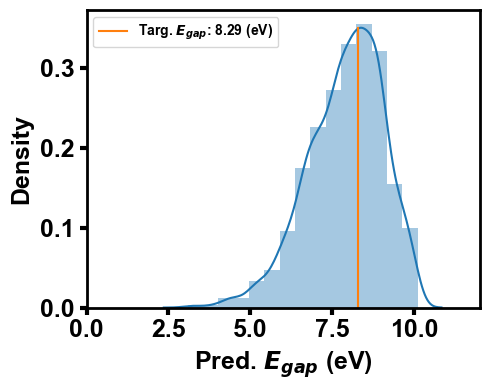

In [36]:
fig, ax = plt.subplots(figsize=(5, 4))
sns.distplot(output['pred_gap'], bins=15,)
plt.plot([output['des_gap'][0], output['des_gap'][0]], [0, 0.35], 
         label='Targ. $E_{gap}$: 8.29 (eV)')
plt.legend()
plt.xlim(0, 12)
np.mean (output['pred_gap'])
[i.set_linewidth(2) for i in ax.spines.values()]


ax.tick_params(axis='both', direction='out', length=5, width=3, colors='black', 
               grid_alpha=0, labelsize='18')


plt.xlabel(r'Pred. $E_{gap}$ (eV)', fontsize=18, 
           fontname='Arial', fontweight="bold", labelpad=5)
plt.ylabel('Density', fontsize=18, 
           fontname='Arial', fontweight="bold", labelpad=5)

plt.tight_layout()
plt.savefig('./single_target.jpeg', dpi=500)